In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from google.colab import drive
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Reference: creating saliency map with tensorflow

In [2]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

def generate_saliency_map(image_path, model, target_layer_idx=-1, target_class_index=0):
    # Load the image and preprocess it
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Assuming VGG16 input size

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Convert the image data to a TensorFlow tensor
    x = tf.convert_to_tensor(x, dtype=tf.float32)

    # Define a model that outputs the activations of the target layer
    activation_model = Model(inputs=model.input, outputs=model.layers[target_layer_idx].output)

    # Compute the gradients of the target class with respect to the model's output
    with tf.GradientTape() as tape:
        tape.watch(x)
        activations = activation_model(x)
        class_output = activations[0][0, target_class_index]  # Assuming a single class output
    grads = tape.gradient(class_output, x)

    # Normalize the gradients
    grads /= (tf.reduce_max(tf.abs(grads)) + 1e-8)

    # Create a saliency map by averaging the absolute gradients across color channels
    saliency_map = np.mean(np.abs(grads[0].numpy()), axis=-1)

    return saliency_map

# Load a pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=True)

# Specify the path to the input image
image_path = 'path_to_your_image.jpg'

# Generate the saliency map
saliency_map = generate_saliency_map(image_path, model)

# Save or display the saliency map
cv2.imwrite('saliency_map.jpg', (saliency_map * 255).astype(np.uint8))

def draw_saliency_map(image_path, saliency_map):
    # Load the original image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the saliency map to match the image size
    saliency_map = cv2.resize(saliency_map, (img.shape[1], img.shape[0]))

    # Normalize the saliency map to the range [0, 1]
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map) + 1e-8)

    # Create a heatmap by applying a colormap (e.g., 'viridis')
    heatmap = plt.get_cmap('viridis')(saliency_map)

    # Overlay the heatmap on the original image
    overlaid_img = (heatmap[:, :, :3] * 255).astype(np.uint8)
    overlaid_img = cv2.addWeighted(overlaid_img, 0.7, img, 0.3, 0)

    # Display the original image, saliency map, and overlaid image
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(saliency_map, cmap='viridis')
    plt.title('Saliency Map')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlaid_img)
    plt.title('Overlaid Image')
    plt.axis('off')

    plt.show()

# Load a pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=True)

# Specify the path to the input image
image_path = 'path_to_your_image.jpg'

# Generate the saliency map
saliency_map = generate_saliency_map(image_path, model)

# Draw and display the saliency map
draw_saliency_map(image_path, saliency_map)

553467096/553467096 [==============================] - 8s 0us/step


error: ignored

In [7]:
from google.colab import drive
drive_dir = '/content/drive'
drive.mount(drive_dir, force_remount=True)
data_dir = 'My Drive/CSCI 2952G Final Project/C-RNNCrispr_data.csv'
data_path = f"{drive_dir}/{data_dir}"
weight_dir = 'My Drive/CSCI 2952G Final Project/C_RNNCrispr_weights.h5'
weight_path = f"{drive_dir}/{weight_dir}"

Mounted at /content/drive


In [ ]:
# data_path = "/content/input_example.csv"
# weight_path = "/content/C_RNNCrispr_weights.h5"

In [8]:
raw_data = pd.read_csv(data_path) # needs to be uploaded from you device
raw_data.head()

,chr_test,start_test,end_test,direction_test,seq_test,ctcf_test,dnase_test,h3k4me3_test,rrbs_test,indel_frequency_test
0,chr6,144167198,144167220,+,AAGAAAGGCGAGCAGAACAGAGG,AAAAAAAAAAAAAAAAAAAAAAA,NNNNNNNNNNNNNNNNNNNNNNN,AAAAAAAAAAAAAAAAAAAAAAA,NNNNNNNNNNNNNNNNNNNNNNN,0.286086
1,chr1,84945112,84945134,-,ATCTCCGAAATGCTAAAGCCTGG,AAAAAAAAAAAAAAAAAAAAAAA,AAAAAAAAAAAAAAAAAAAAAAA,AAAAAAAAAAAAAAAAAAAAAAA,NNNNNNNNNNNNNNNNNNNNNNN,0.118030
2,chr3,45761034,45761056,+,ATTGGATTCTCATCTCGAGGAGG,AAAAAAAAAAAAAAAAAAAAAAA,AAAAAAAAAAAAAAAAAAAAAAA,AAAAAAAAAAAAAAAAAAAAAAA,NNNNNNNNNNNNNNNNNNNNNNN,0.389621
3,chr6,43487847,43487869,-,GGTTCCGAGTGCATCTGACCTGG,AAAAAAAAAAAAAAAAAAAAAAA,AAAAAAAAAAAAAAAAAAAAAAA,NNNNNNNNNNNNNNNNNNNNNNN,NNNNNNNNNNNNNNNNNNNNNNN,0.632815
4,chr2,219445420,219445442,-,ACCAAATGAATGCCACAGCATGG,AAAAAAAAAAAAAAAAAAAAAAA,AAAAAAAAAAAAAAAAAAAAAAA,AAAAAAAAAAAAAAAAAAAAAAA,NNNNNNNNNNNNNNNNNNNNNNN,0.214328


In [9]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, GRU, Bidirectional
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution1D, MaxPooling1D
from tensorflow.keras.layers import Multiply

def grna_preprocess(lines):
    length = 23
    data_n = len(lines)
    seq = np.zeros((data_n, length, 4), dtype=int)
    for l in range(data_n):
        data = lines[l]
        seq_temp = data
        for i in range(length):
            if seq_temp[i] in "Aa":
                seq[l, i, 0] = 1
            elif seq_temp[i] in "Cc":
                seq[l, i, 1] = 1
            elif seq_temp[i] in "Gg":
                seq[l, i, 2] = 1
            elif seq_temp[i] in "Tt":
                seq[l, i, 3] = 1
    return seq


def epi_preprocess(lines):
    length = 23
    data_n = len(lines)
    epi = np.zeros((data_n, length), dtype=int)
    for l in range(data_n):
        data = lines[l]
        epi_temp = data
        for i in range(length):
            if epi_temp[i] in "A":
                epi[l, i] = 1
            elif epi_temp[i] in "N":
                epi[l, i] = 0
    return epi


def preprocess(file_path, usecols):
    data = pd.read_csv(file_path, usecols=usecols)
    data = np.array(data)
    epi_1, epi_2, epi_3, epi_4 = epi_preprocess(data[:, 0]), epi_preprocess(data[:, 1]), epi_preprocess(data[:, 2]), epi_preprocess(data[:, 3])
    epi = []
    for i in range(len(data)):
        epi_1_temp, epi_2_temp, epi_3_temp, epi_4_temp = pd.DataFrame(epi_1[i]), pd.DataFrame(epi_2[i]), pd.DataFrame(
            epi_3[i]), pd.DataFrame(epi_4[i])
        epi_temp = pd.concat([epi_1_temp, epi_2_temp, epi_3_temp, epi_4_temp], axis=1)
        epi_temp = np.array(epi_temp)
        epi.append(epi_temp)
    epi = np.array(epi)
    return epi


def load_data(test_file):
    test_data = pd.read_csv(test_file, usecols=[4, 9])
    test_data = np.array(test_data)
    x_test, y_test = test_data[:, 0], test_data[:, 1]
    x_test = grna_preprocess(x_test)
    epi_test = preprocess(test_file, [5, 6, 7, 8])
    y_test = y_test.reshape(len(y_test), -1)
    return x_test, epi_test, y_test

def build_CRNNCrispr():
    seq_input = Input(shape=(23, 4))
    seq_conv1 = Convolution1D(256, 5, kernel_initializer='random_uniform', name='seq_conv1')(seq_input)
    seq_act1 = Activation('relu')(seq_conv1)
    seq_pool1 = MaxPooling1D(2)(seq_act1)
    seq_drop1 = Dropout(0.2)(seq_pool1)
    gru1 = Bidirectional(GRU(256, kernel_initializer='he_normal', dropout=0.3, recurrent_dropout=0.2, reset_after=False), name='gru1')(seq_drop1)
    seq_dense1 = Dense(256, name='seq_dense1')(gru1)
    seq_act2 = Activation('relu')(seq_dense1)
    seq_drop2 = Dropout(0.3)(seq_act2)
    seq_dense2 = Dense(128, name='seq_dense2')(seq_drop2)
    seq_act3 = Activation('relu')(seq_dense2)
    seq_drop3 = Dropout(0.2)(seq_act3)
    seq_dense3 = Dense(64, name='seq_dense3')(seq_drop3)
    seq_act4 = Activation('relu')(seq_dense3)
    seq_drop4 = Dropout(0.2)(seq_act4)
    seq_dense4 = Dense(40, name='seq_dense4')(seq_drop4)
    seq_act5 = Activation('relu')(seq_dense4)
    seq_drop5 = Dropout(0.2)(seq_act5)

    epi_input = Input(shape=(23, 4))
    epi_conv1 = Convolution1D(256, 5, name='epi_conv1')(epi_input)
    epi_act1 = Activation('relu')(epi_conv1)
    epi_pool1 = MaxPooling1D(2)(epi_act1)
    epi_drop1 = Dropout(0.3)(epi_pool1)
    epi_dense1 = Dense(256, name='epi_dense1')(epi_drop1)
    epi_act2 = Activation('relu')(epi_dense1)
    epi_drop2 = Dropout(0.2)(epi_act2)
    epi_dense2 = Dense(128, name='epi_dense2')(epi_drop2)
    epi_act3 = Activation('relu')(epi_dense2)
    epi_drop3 = Dropout(0.3)(epi_act3)
    epi_dense3 = Dense(64, name='epi_dense3')(epi_drop3)
    epi_act4 = Activation('relu')(epi_dense3)
    epi_drop4 = Dropout(0.3)(epi_act4)
    epi_act5 = Dense(40, name='epi_dense4')(epi_drop4)
    epi_out = Activation('relu')(epi_act5)

    seq_epi_m = Multiply()([seq_drop5, epi_out])
    seq_epi_drop = Dropout(0.2)(seq_epi_m)
    seq_epi_flat = Flatten()(seq_epi_drop)
    seq_epi_output = Dense(1, activation='linear')(seq_epi_flat)

    return Model(inputs=[seq_input, epi_input], outputs=[seq_epi_output])

Try out CRNNCrispr

In [10]:
print("Loading weights for the models")
model = build_CRNNCrispr()
model.load_weights(weight_path) # needs to upload

print("Loading test data")
x_test, epi_test, y_test = load_data(data_path) # needs to upload

print("input sequence data shape: " + str(x_test.shape))
print("input epigenetic data shape: " + str(epi_test.shape))

print("Predicting on test data")
y_pred = model.predict([x_test, epi_test], batch_size=256, verbose=2)
print("output prediction shape: " + str(y_pred.shape))
print("output target shape: " + str(y_test.shape))

# result = pd.concat([y_test, y_pred], axis=1)
# result.to_csv(result_file, index=False, sep=',', header=['y_test', 'y_pred'])


Loading weights for the models
Loading test data
input sequence data shape: (848, 23, 4)
input epigenetic data shape: (848, 23, 4)
Predicting on test data
4/4 - 1s - 1s/epoch - 286ms/step
output prediction shape: (848, 1)
output target shape: (848, 1)


Saliency Map for CRNNCrispr

In [11]:
from tensorflow.keras.models import Model

def generate_saliency_map(seq_input, epi_input, model, target_layer_idx=-1):
    # Finds the target layer
    target_layer = Model(inputs=model.input, outputs=model.layers[target_layer_idx].output)

    # Compute the gradients of the target class with respect to the model's output
    seq = tf.convert_to_tensor(seq_input, dtype=tf.float32)
    epi = tf.convert_to_tensor(epi_input, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(seq)
        tape.watch(epi)
        output = target_layer([seq, epi])
    grads = tape.gradient(output, [seq, epi])

    # Normalize the gradients
    grads /= (tf.reduce_max(tf.abs(grads)) + 1e-8)

    # Create a saliency map by averaging the absolute gradients across color channels
    # saliency_map = np.mean(np.abs(grads[0]), axis=-1)
    saliency_map_seq = grads[0]
    saliency_map_epi = grads[1]

    return saliency_map_seq, saliency_map_epi

In [12]:
saliency_map_seq, saliency_map_epi = generate_saliency_map(x_test, epi_test, model)
prediction = model([x_test, epi_test])
label = y_test
print(saliency_map_seq.shape)
print(saliency_map_epi.shape)
print(prediction.shape)
print(label.shape)

(848, 23, 4)
(848, 23, 4)
(848, 1)
(848, 1)


In [13]:
def count_nonzero_grad(saliency_map):
    count = 0
    for i in saliency_map:
        if np.any(i):
            count += 1
    return count

print(str(count_nonzero_grad(saliency_map_seq)) + " out of " + str(len(saliency_map_seq))
+ " samples in the saliency map of the sequencial inputs are nonzero")
print(str(count_nonzero_grad(saliency_map_epi)) + " out of " + str(len(saliency_map_epi))
+ " samples in the saliency map of the epigenetics inputs are nonzero")

326 out of 848 samples in the saliency map of the sequencial inputs are nonzero
0 out of 848 samples in the saliency map of the epigenetics inputs are nonzero


In [14]:
def find_max(saliency_map):
    max = 0
    index = 0
    for i in range(len(saliency_map)):
        cur = np.sum(np.abs(np.array(saliency_map[i]).ravel()))
        if cur > max:
            max = cur
            index = i
    return max, index
find_max(saliency_map_seq)

(25.706615, 475)

In [45]:
def draw_saliency_map(saliency_map):
    # Normalize the saliency map to the range [0, 1]
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map) + 1e-8)

    # Transpose the map to match the format in the paper
    saliency_map = np.transpose(saliency_map)

    # Create a heatmap by applying a colormap (e.g., 'viridis')
    heatmap = plt.get_cmap('viridis')(saliency_map)

    # Display the original image, saliency map, and overlaid image
    plt.figure(figsize=(12, 6))
    plt.imshow(saliency_map, cmap='viridis')
    plt.colorbar()

    plt.title('Saliency Map')
    y_ticks = np.arange(0, 4, 1)  # Custom tick locations
    y_tick_labels = ['A', 'C', 'G', 'T']  # Custom tick labels

    x_ticks = np.arange(0, 23, 1)  # Custom tick locations
    x_tick_labels = np.arange(1, 24, 1)  # Custom tick labels

    plt.xticks(x_ticks, x_tick_labels)
    plt.yticks(y_ticks, y_tick_labels)

    plt.xlabel('Genomic Position')
    plt.ylabel('Nucleotide')

    plt.show()

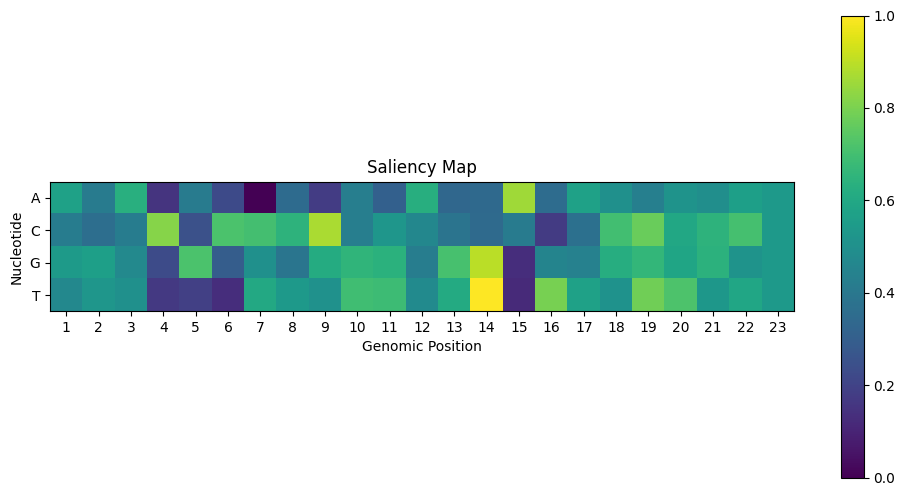

In [46]:
# seq_example = np.expand_dims(saliency_map_seq[475], axis=0)
seq_example = saliency_map_seq[475]
draw_saliency_map(seq_example)